In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import datetime
import copy
import time
import os
import sys
sys.path.append('../../')

from data.processing import get_data

import models

from main.seir.fitting import single_fitting_cycle
from main.seir.forecast import get_forecast, forecast_all_trials, create_all_trials_csv, create_decile_csv_new
from main.seir.sensitivity import calculate_sensitivity_and_plot
from utils.generic.create_report import save_dict_and_create_report
from utils.generic.config import read_config
from utils.generic.enums import Columns
from utils.fitting.loss import Loss_Calculator
#from utils.generic.logging import log_wandb
from viz import plot_forecast, plot_top_k_trials, plot_ptiles, plot_ptiles_comp
from viz.fit import plot_all_losses

import yaml

In [3]:
from os.path import exists, join, splitext

In [4]:
predictions_dict_m = {}


In [5]:
config_filename1 = 'default.yaml'
config_filename2 = 'uncer.yaml'
config1 = read_config(config_filename1)
config2 = read_config(config_filename2)

Performing m1 fit ..
loading from ../../misc/cache/dataframes_ts_07012021_tracker.pkl
splitting data ..
splitting data ..
train
 +-------------+---------------------+---------------------+---------------------+---------------------+---------------------+
|             | 181                 | 182                 | 183                 | 184                 | 185                 |
|-------------+---------------------+---------------------+---------------------+---------------------+---------------------|
| date        | 2020-10-24 00:00:00 | 2020-10-25 00:00:00 | 2020-10-26 00:00:00 | 2020-10-27 00:00:00 | 2020-10-28 00:00:00 |
| state       | Maharashtra         | Maharashtra         | Maharashtra         | Maharashtra         | Maharashtra         |
| district    | Mumbai              | Mumbai              | Mumbai              | Mumbai              | Mumbai              |
| total       | 249759.14           | 250955.0            | 252085.0            | 252886.0            | 254240.0   

/Users/avtansht/anaconda3/envs/C19M/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


100%|██████████| 2000/2000 [01:17<00:00, 25.87trial/s, best loss: 0.9493018197649854]
best parameters
 {'E_hosp_ratio': 0.5176135674217907, 'I_hosp_ratio': 0.2567770014206377, 'P_fatal': 0.02539074841103146, 'T_inc': 4.977568857553627, 'T_inf': 3.3462682661116707, 'T_recov': 11.308621920308715, 'T_recov_fatal': 14.908242540565766, 'lockdown_R0': 0.7335118400363224}


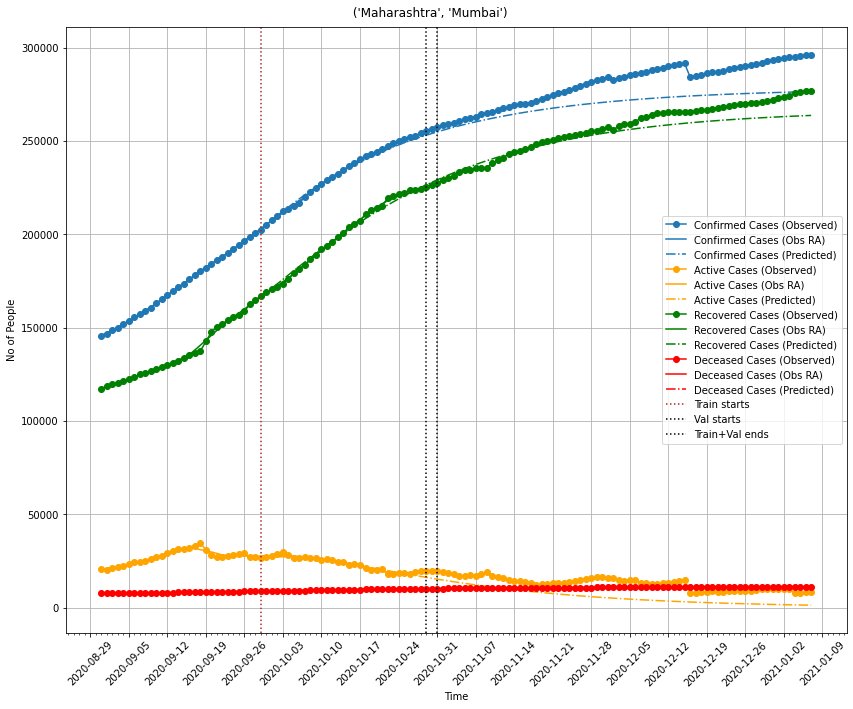

In [6]:
predictions_dict_b = {}
predictions_dict_b['m1'] = single_fitting_cycle(**copy.deepcopy(config1['fitting']))

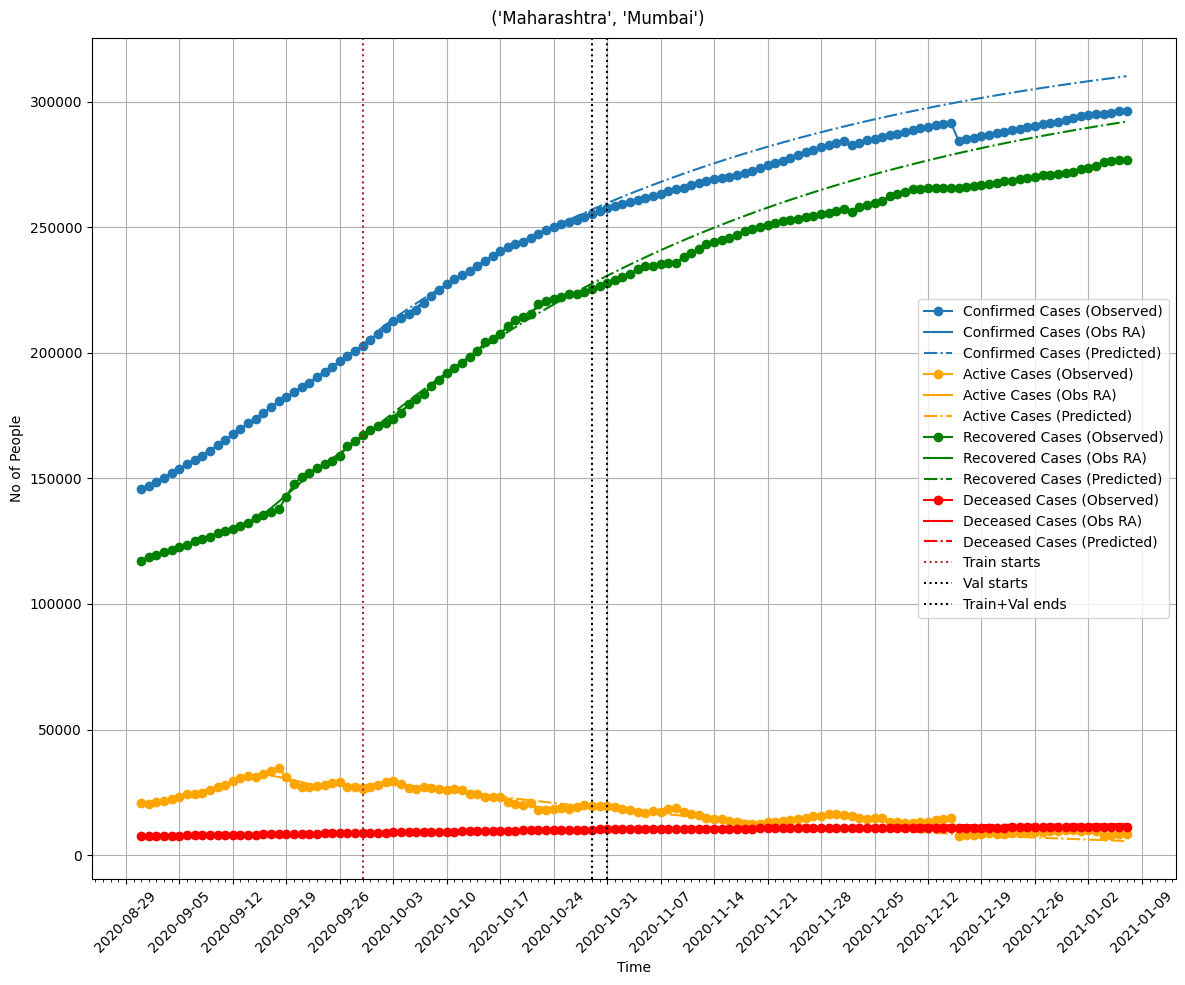

In [7]:
import pickle as pkl
with open('../../misc/predictions/mumbai_base.pickle', 'rb') as handle:
    predictions_dict_m = pkl.load(handle)

In [8]:
predictions_dict_m['m1']['forecasts'] = {}        
predictions_dict_m['m1']['forecasts']['best'] = get_forecast(predictions_dict_m, train_fit='m1', 
                                                                model=config2['fitting']['model'], 
                                                                forecast_days=config2['forecast']['forecast_days'])

getting forecasts ..


In [9]:
predictions_dict_b['m1']['forecasts'] = {}
predictions_dict_b['m1']['forecasts']['best'] = get_forecast(predictions_dict_b, train_fit='m1', 
                                                                model=config1['fitting']['model'], 
                                                                forecast_days=config1['forecast']['forecast_days'])

getting forecasts ..


In [10]:
predictions_dict_m['m1']['trials_processed'] = forecast_all_trials(predictions_dict_m, train_fit='m1', 
                                                                        model=config2['fitting']['model'], 
                                                                        forecast_days=config2['forecast']['forecast_days'])

13it [00:00, 122.75it/s]

getting forecasts ..


2000it [00:15, 128.07it/s]


In [11]:
predictions_dict_b['m1']['trials_processed'] = forecast_all_trials(predictions_dict_b, train_fit='m1', 
                                                                        model=config2['fitting']['model'], 
                                                                        forecast_days=config2['forecast']['forecast_days'])

11it [00:00, 106.50it/s]

getting forecasts ..


2000it [00:17, 113.63it/s]


In [12]:
uncertainty_args_m = {'predictions_dict': predictions_dict_m, 'fitting_config': config2['fitting'],
                    'forecast_config': config2['forecast'], **config2['uncertainty']['uncertainty_params']}
uncertainty_args_b = {'predictions_dict': predictions_dict_b, 'fitting_config': config1['fitting'],
                    'forecast_config': config1['forecast'], **config1['uncertainty']['uncertainty_params']}

# Total

In [13]:
config_filename1 = 'default.yaml'
config_filename2 = 'uncer.yaml'
config1 = read_config(config_filename1)
config2 = read_config(config_filename2)
uncertainty_args_m = {'predictions_dict': predictions_dict_m, 'fitting_config': config2['fitting'],
                    'forecast_config': config2['forecast'], **config2['uncertainty']['uncertainty_params']}
uncertainty_args_b = {'predictions_dict': predictions_dict_b, 'fitting_config': config1['fitting'],
                    'forecast_config': config1['forecast'], **config1['uncertainty']['uncertainty_params']}
config1['uncertainty']['uncertainty_params']['sort_trials_by_column']


<Columns.total: Column(name='total', label='Confirmed Cases', color='C0')>

In [14]:
uncertainty_m = config2['uncertainty']['method'](**uncertainty_args_m)
predictions_dict_m['uncertainty_forecasts'] = uncertainty_m.get_forecasts()
predictions_dict_m['ensemble_mean_forecast'] = uncertainty_m.ensemble_mean_forecast
print('BO')
uncertainty_b = config1['uncertainty']['method'](**uncertainty_args_b)
predictions_dict_b['uncertainty_forecasts'] = uncertainty_b.get_forecasts()
predictions_dict_b['ensemble_mean_forecast'] = uncertainty_b.ensemble_mean_forecast
PD_t= {}
PD_t['MCMC'] = predictions_dict_m.copy()
PD_t['BO'] = predictions_dict_b.copy()

14it [00:00, 135.15it/s]

getting forecasts ..


2000it [00:13, 143.79it/s]
14it [00:00, 136.42it/s]

BO
getting forecasts ..


2000it [00:15, 130.78it/s]
100%|██████████| 101/101 [02:26<00:00,  1.45s/it]


Best beta - 0.0
Min Loss - 3.54465786032076


# Active

In [15]:
config_filename1 = 'default.yaml'
config_filename2 = 'uncer.yaml'
config1 = read_config(config_filename1)
config2 = read_config(config_filename2)
uncertainty_args_m = {'predictions_dict': predictions_dict_m, 'fitting_config': config2['fitting'],
                    'forecast_config': config2['forecast'], **config2['uncertainty']['uncertainty_params']}
uncertainty_args_b = {'predictions_dict': predictions_dict_b, 'fitting_config': config1['fitting'],
                    'forecast_config': config1['forecast'], **config1['uncertainty']['uncertainty_params']}
config1['uncertainty']['uncertainty_params']['sort_trials_by_column']

<Columns.active: Column(name='active', label='Active Cases', color='orange')>

In [16]:
uncertainty_m = config2['uncertainty']['method'](**uncertainty_args_m)
predictions_dict_m['uncertainty_forecasts'] = uncertainty_m.get_forecasts()
predictions_dict_m['ensemble_mean_forecast'] = uncertainty_m.ensemble_mean_forecast
uncertainty_b = config1['uncertainty']['method'](**uncertainty_args_b)
predictions_dict_b['uncertainty_forecasts'] = uncertainty_b.get_forecasts()
predictions_dict_b['ensemble_mean_forecast'] = uncertainty_b.ensemble_mean_forecast
PD_a= {}
PD_a['MCMC'] = predictions_dict_m.copy()
PD_a['BO'] = predictions_dict_b.copy()

12it [00:00, 116.34it/s]

getting forecasts ..


2000it [00:16, 124.92it/s]
11it [00:00, 104.07it/s]

getting forecasts ..


2000it [00:16, 122.32it/s]
100%|██████████| 101/101 [02:23<00:00,  1.42s/it]


Best beta - 0.0
Min Loss - 3.54465786032076


# Recovered

In [17]:
config_filename1 = 'default.yaml'
config_filename2 = 'uncer.yaml'
config1 = read_config(config_filename1)
config2 = read_config(config_filename2)
uncertainty_args_m = {'predictions_dict': predictions_dict_m, 'fitting_config': config2['fitting'],
                    'forecast_config': config2['forecast'], **config2['uncertainty']['uncertainty_params']}
uncertainty_args_b = {'predictions_dict': predictions_dict_b, 'fitting_config': config1['fitting'],
                    'forecast_config': config1['forecast'], **config1['uncertainty']['uncertainty_params']}
config1['uncertainty']['uncertainty_params']['sort_trials_by_column']


<Columns.recovered: Column(name='recovered', label='Recovered', color='green')>

In [18]:
uncertainty_m = config2['uncertainty']['method'](**uncertainty_args_m)
predictions_dict_m['uncertainty_forecasts'] = uncertainty_m.get_forecasts()
predictions_dict_m['ensemble_mean_forecast'] = uncertainty_m.ensemble_mean_forecast
uncertainty_b = config1['uncertainty']['method'](**uncertainty_args_b)
predictions_dict_b['uncertainty_forecasts'] = uncertainty_b.get_forecasts()
predictions_dict_b['ensemble_mean_forecast'] = uncertainty_b.ensemble_mean_forecast
PD_r= {}
PD_r['MCMC'] = predictions_dict_m.copy()
PD_r['BO'] = predictions_dict_b.copy()

13it [00:00, 125.74it/s]

getting forecasts ..


2000it [00:15, 127.84it/s]
13it [00:00, 128.87it/s]

getting forecasts ..


2000it [00:15, 125.65it/s]
100%|██████████| 101/101 [02:24<00:00,  1.43s/it]


Best beta - 0.0
Min Loss - 3.54465786032076


# Deceased

In [19]:
config_filename1 = 'default.yaml'
config_filename2 = 'uncer.yaml'
config1 = read_config(config_filename1)
config2 = read_config(config_filename2)
uncertainty_args_m = {'predictions_dict': predictions_dict_m, 'fitting_config': config2['fitting'],
                    'forecast_config': config2['forecast'], **config2['uncertainty']['uncertainty_params']}
uncertainty_args_b = {'predictions_dict': predictions_dict_b, 'fitting_config': config1['fitting'],
                    'forecast_config': config1['forecast'], **config1['uncertainty']['uncertainty_params']}
config1['uncertainty']['uncertainty_params']['sort_trials_by_column']

<Columns.deceased: Column(name='deceased', label='Deceased', color='red')>

In [20]:
uncertainty_m = config2['uncertainty']['method'](**uncertainty_args_m)
predictions_dict_m['uncertainty_forecasts'] = uncertainty_m.get_forecasts()
predictions_dict_m['ensemble_mean_forecast'] = uncertainty_m.ensemble_mean_forecast
uncertainty_b = config1['uncertainty']['method'](**uncertainty_args_b)
predictions_dict_b['uncertainty_forecasts'] = uncertainty_b.get_forecasts()
predictions_dict_b['ensemble_mean_forecast'] = uncertainty_b.ensemble_mean_forecast
PD_d= {}
PD_d['MCMC'] = predictions_dict_m.copy()
PD_d['BO'] = predictions_dict_b.copy()

13it [00:00, 121.93it/s]

getting forecasts ..


2000it [00:14, 136.77it/s]
13it [00:00, 129.05it/s]

getting forecasts ..


2000it [00:16, 121.68it/s]
100%|██████████| 101/101 [02:30<00:00,  1.49s/it]


Best beta - 0.0
Min Loss - 3.54465786032076


In [25]:
import matplotlib as mpl
## for Palatino and other serif fonts use:
plt.rcParams.update({
    'font.size': 20,
 })

total
active
recovered
deceased


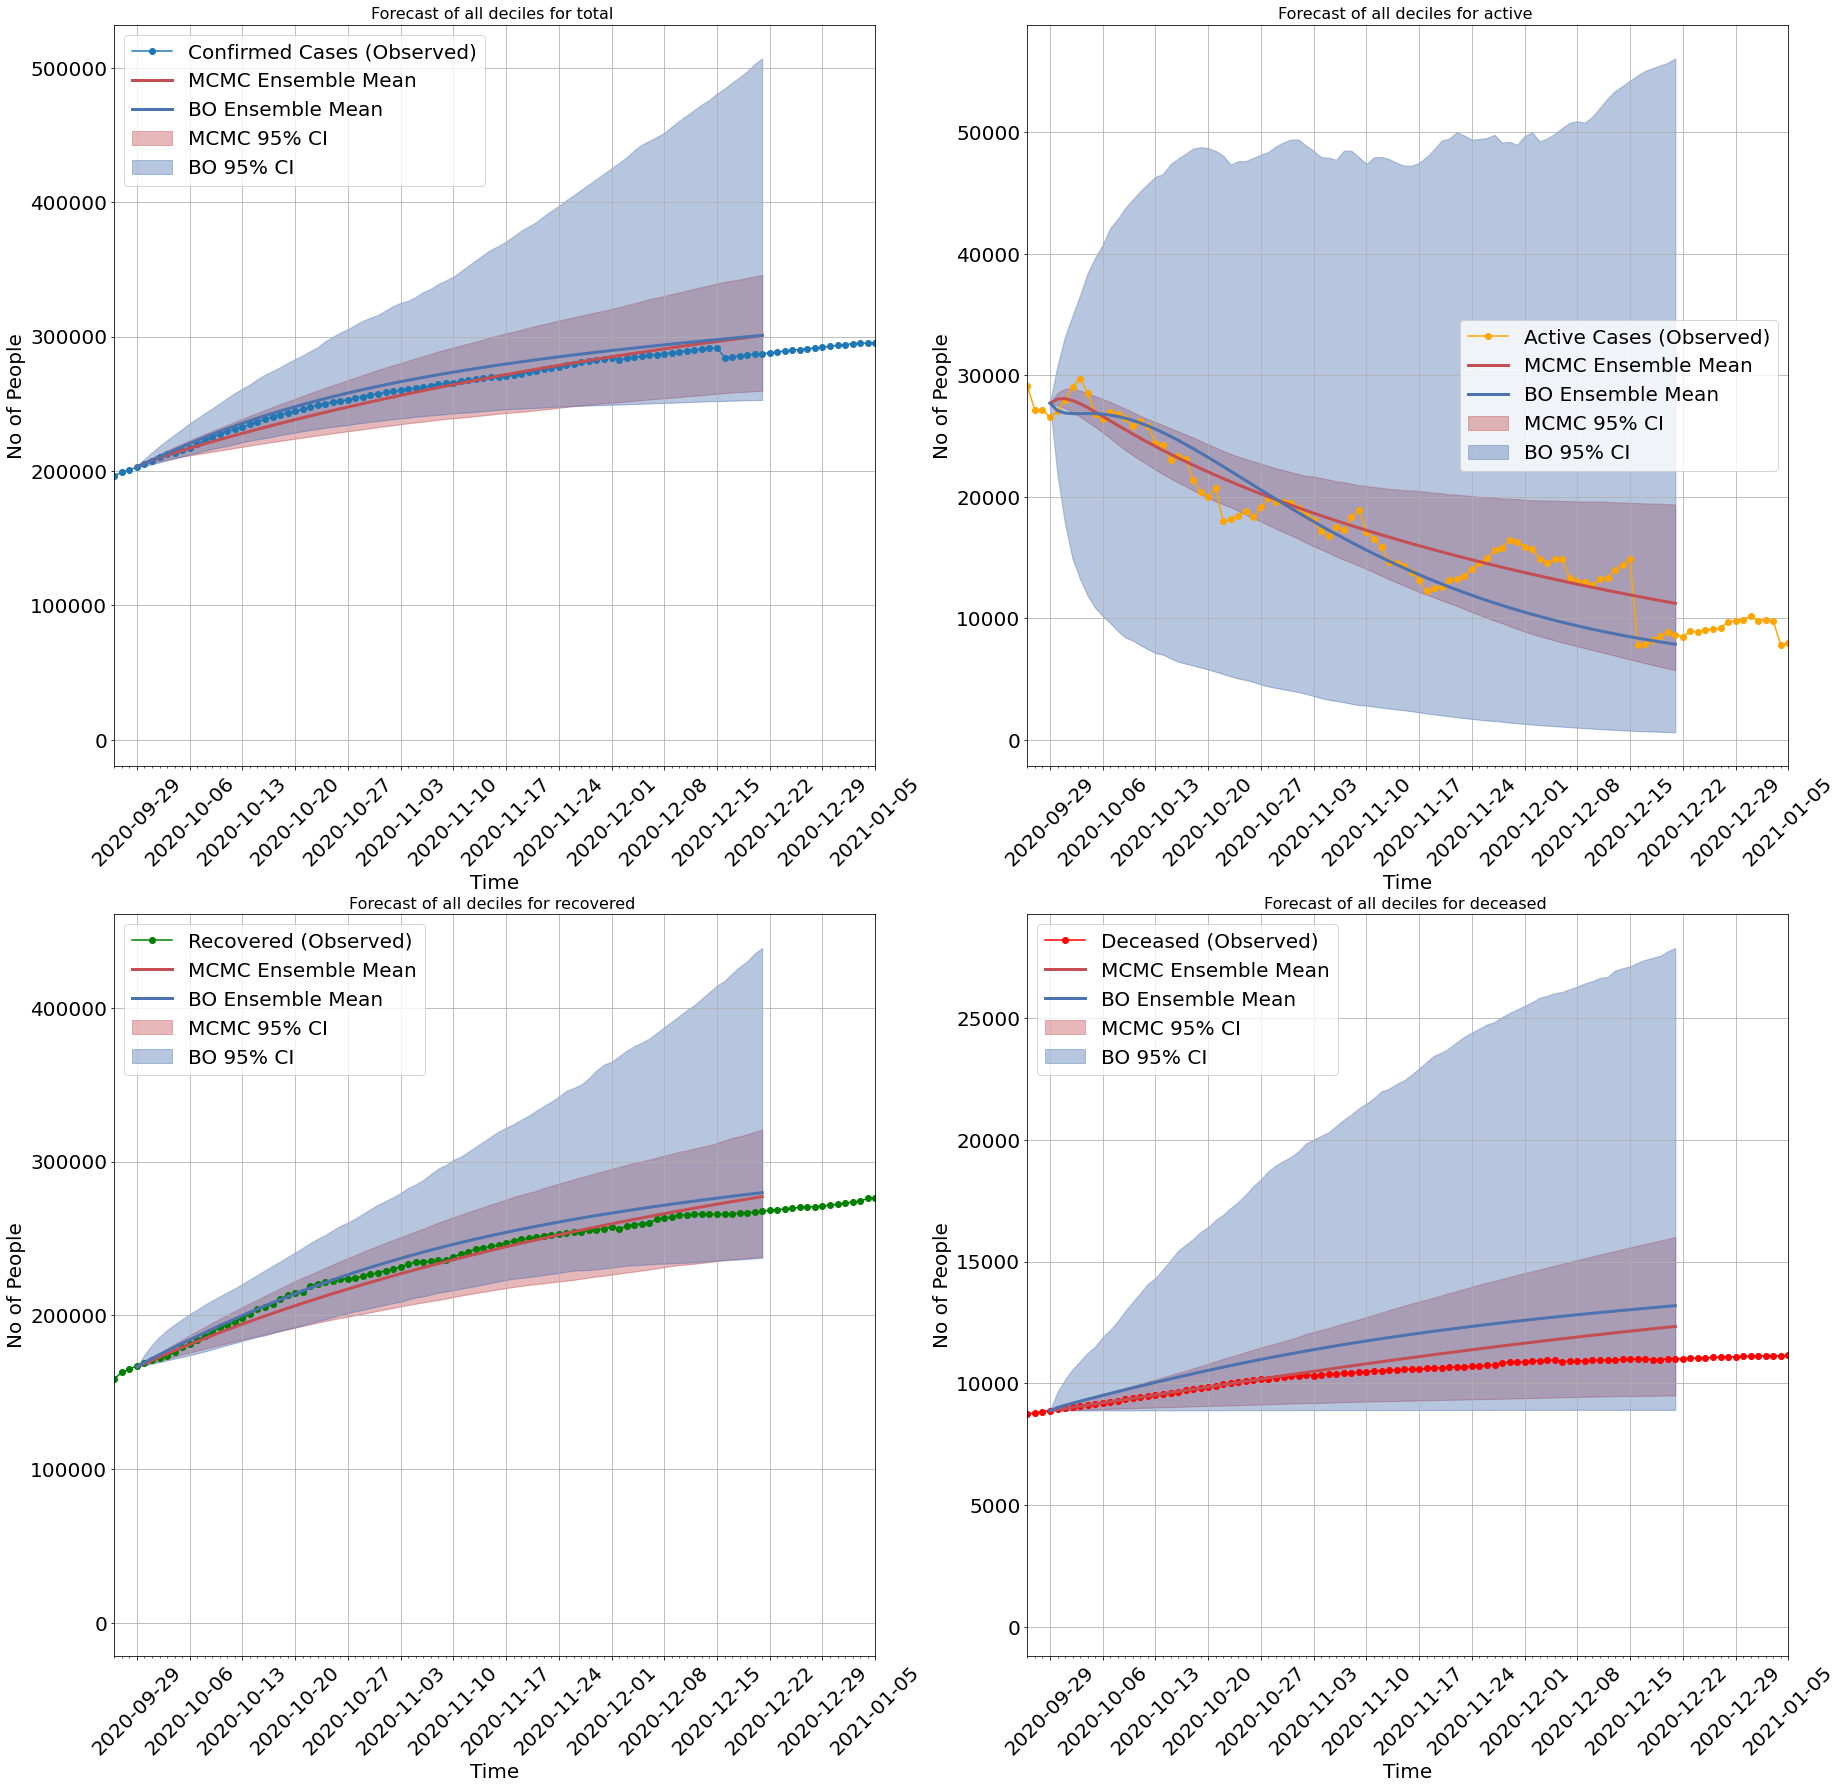

In [27]:
fig,axs = plt.subplots(figsize=(30,30),nrows=2,ncols=2) 
plot_ptiles_comp(PD_t, compartment=config1['forecast']['plot_ptiles_for_columns'][0],ax=axs.flat[0])
plot_ptiles_comp(PD_a, compartment=config1['forecast']['plot_ptiles_for_columns'][1],ax=axs.flat[1])
plot_ptiles_comp(PD_r, compartment=config1['forecast']['plot_ptiles_for_columns'][2],ax=axs.flat[2])
plot_ptiles_comp(PD_d, compartment=config1['forecast']['plot_ptiles_for_columns'][3],ax=axs.flat[3])
fig.savefig('/Users/avtansht/Desktop/Desktop/Wadhwani/Plots_final/CI.pdf',  format='pdf', bbox_inches='tight', pad_inches=0)